# Semantic Segmentation Mini Project

#### You can get the dataset from https://www.kaggle.com/greysky/pencil-dataset

In [ ]:
import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 25
BATCH_SIZE = 8

### Model Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.down_1 = self.double_conv(3, 32)
    self.down_sampling_1 = nn.MaxPool2d(2, 2)
    self.down_2 = self.double_conv(32, 64)
    self.down_sampling_2 = nn.MaxPool2d(2, 2)

    self.bottleneck = nn.Conv2d(64, 128, 3, 1, 1)

    self.up_sampling_1 = nn.ConvTranspose2d(128, 64, 2, 2)
    self.up_1 = self.double_conv(128, 64)
    self.up_sampling_2 = nn.ConvTranspose2d(64, 32, 2, 2)
    self.up_2 = self.double_conv(64, 32)

    self.final = nn.Conv2d(32, 3, 1)

  def forward(self, x):
    x = skip_1 = self.down_1(x)
    x = self.down_sampling_1(x)
    x = skip_2 = self.down_2(x)
    x = self.down_sampling_2(x)

    x = self.bottleneck(x)

    x = self.up_sampling_1(x)
    x = self.up_1(torch.cat([skip_2, x], axis=1))
    x = self.up_sampling_2(x)
    x = self.up_2(torch.cat([skip_1, x], axis=1))

    return torch.softmax(self.final(x), 1)

  def double_conv(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )

### Custom Dataset

In [ ]:
class PencilDataset(Dataset):
  def __init__(self, root, transform=None):
    super().__init__()
    self.root = root
    self.classes = ["none", "red_pencil", "green_pencil"]
    self.img_paths = glob.glob(f"{root}/*.jpg")
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path)
    target = self.json_to_mask(img_path.replace('.jpg', '.json'))

    if self.transform:
      augmented = self.transform(image=np.array(image), mask=np.array(target))
      image, target = augmented['image'], augmented['mask']
      image, target = torch.from_numpy(image), torch.from_numpy(target)
      image = image.permute(2, 0, 1)
      image = image / 255.0

    target = target.to(torch.long)  
    return image, target

  def json_to_mask(self, json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
      dj = json.load(f)
      
      mask = np.zeros((dj['image_height'], dj['image_width']), dtype=np.uint8)
      mask = PIL.Image.fromarray(mask)
      draw = PIL.ImageDraw.Draw(mask)

      for obj in dj['objects']:
        idx = 1 if obj['category'] == 'red_pencil' else 2
        
        for points in obj['segmentation']:
          xy = [tuple([points[i], points[i + 1]]) for i in range(0, len(points), 2)]
          draw.polygon(xy=xy, outline=idx, fill=idx)
      
      return mask

### Plot Function

In [ ]:
def plot_images(data_iter, n_samples):
  imgs, targets = next(data_iter)
  fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

  for img, target, ax in zip(imgs, targets, axes[0]):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

  for img, target, ax in zip(imgs, targets, axes[1]):
    target[0, [0, 1, 2]] = torch.tensor([0, 1, 2])
    ax.axis("off")
    ax.imshow(target)

### Transforms

In [ ]:
train_transform = A.Compose([
    A.RandomCrop(height=800, width=800),
    A.RandomRotate90(p=1.0),
    A.Resize(height=128, width=128),
])

valid_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

test_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

### Dataset Initialization

In [ ]:
train_set = PencilDataset('dataset/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_iter = iter(train_loader)

valid_set = PencilDataset('dataset/valid', transform=valid_transform)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iter = iter(valid_loader)

test_set = PencilDataset('dataset/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = iter(test_loader)

### Train Samples

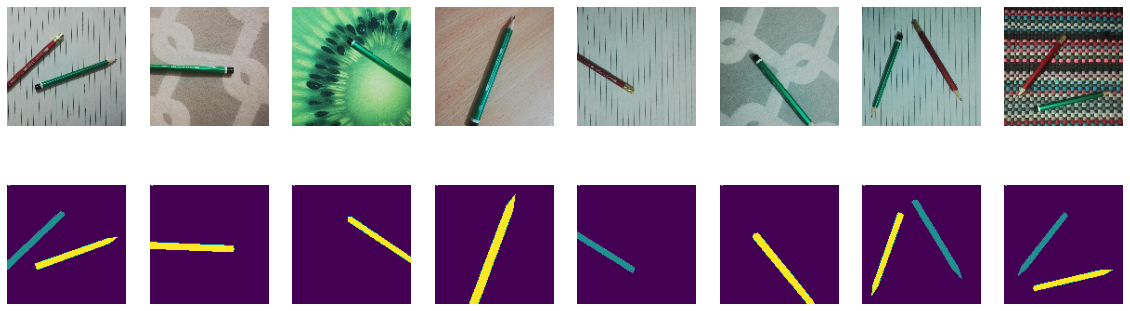

In [ ]:
plot_images(train_iter, 8)

### Valid Samples

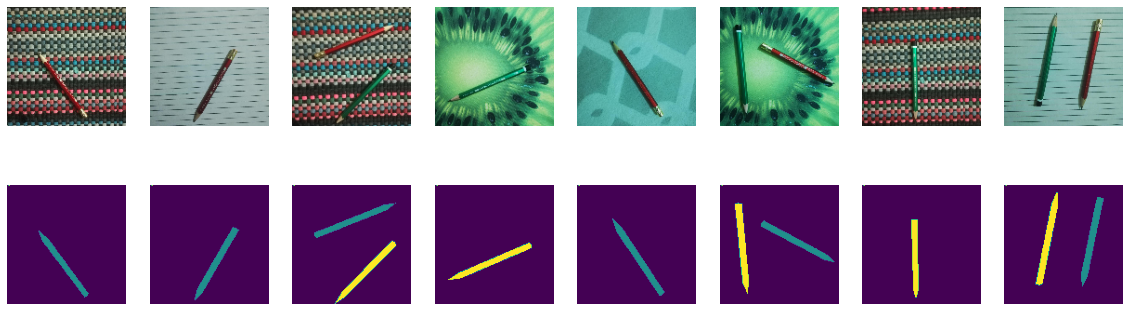

In [ ]:
plot_images(valid_iter, 8)

### Test Samples

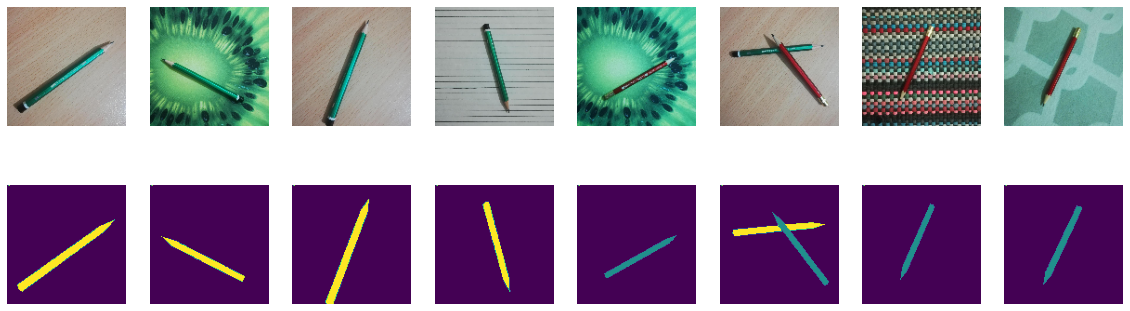

In [ ]:
plot_images(test_iter, 8)

### Model Initialization

In [ ]:
class_weights = torch.tensor([0.4, 1.0, 1.0]).to(DEVICE)

model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

### Train Function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

### Validation Function

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

### Training

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, criterion)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, criterion)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 0.9209    vloss: 0.8488
2.loss: 0.7741    vloss: 0.7257
3.loss: 0.6880    vloss: 0.6661
4.loss: 0.6411    vloss: 0.6378
5.loss: 0.6148    vloss: 0.6110
6.loss: 0.5994    vloss: 0.5962
7.loss: 0.5891    vloss: 0.5837
8.loss: 0.5814    vloss: 0.5793
9.loss: 0.5772    vloss: 0.5789
10.loss: 0.5764    vloss: 0.5735
11.loss: 0.5729    vloss: 0.5751
12.loss: 0.5699    vloss: 0.5705
13.loss: 0.5690    vloss: 0.5680
14.loss: 0.5694    vloss: 0.5675
15.loss: 0.5673    vloss: 0.5682
16.loss: 0.5668    vloss: 0.5692
17.loss: 0.5652    vloss: 0.5653
18.loss: 0.5644    vloss: 0.5646
19.loss: 0.5641    vloss: 0.5644
20.loss: 0.5634    vloss: 0.5623
21.loss: 0.5628    vloss: 0.5626
22.loss: 0.5658    vloss: 0.5649
23.loss: 0.5645    vloss: 0.5647
24.loss: 0.5631    vloss: 0.5632
25.loss: 0.5632    vloss: 0.5626


### Loss Graph

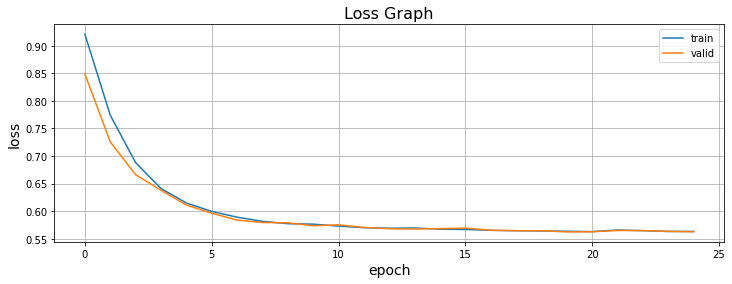

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Plot Functions

In [ ]:
def plot_predictions(data_iter, model, n_samples):
  imgs, targets = next(data_iter)

  model.eval()
  with torch.no_grad():
    preds = model(imgs.to(DEVICE)).argmax(1).to('cpu')

  fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

  for img, pred, ax in zip(imgs, preds, axes[0]):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

  for img, pred, ax in zip(imgs, preds, axes[1]):
    pred[0, [0, 1, 2]] = torch.tensor([0, 1, 2])
    ax.axis("off")
    ax.imshow(pred)

In [ ]:
def plot_confusion_matrix(loader, model):
  cmat = np.zeros((3, 3))
  num_pixels = np.zeros((3,))

  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(DEVICE)
      y_pred = model(x)
      y_pred = y_pred.to("cpu")
      y_pred = y_pred.argmax(1)
      
      for y_1, y_2 in zip(y.reshape(-1), y_pred.reshape(-1)):
        cmat[y_1][y_2] += 1
        num_pixels[y_1] += 1
  
  cmat = cmat / num_pixels[:, None]
      
  plt.figure(figsize = (4, 4))
  plt.matshow(cmat, fignum=1, cmap=plt.cm.copper)

  plt.xticks([0, 1, 2], ["none", "red", "green"], rotation="vertical", fontsize=14)
  plt.yticks([0, 1, 2], ["none", "red", "green"], rotation="horizontal", fontsize=14)

  plt.xlabel("predictions", fontsize=16)
  plt.ylabel("targets", fontsize=16)

  for i in range(3):
    for j in range(3):
      plt.text(i, j, f'{cmat[j][i]:0.4f}', color="white", horizontalalignment="center")
  plt.show()

### Testing

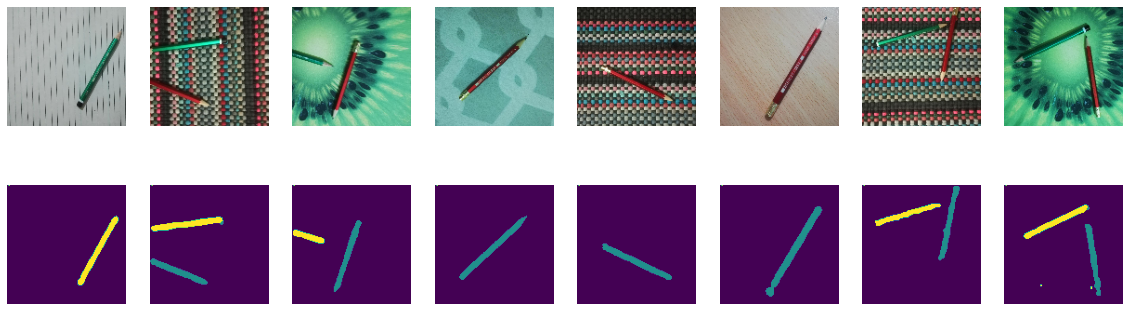

In [ ]:
plot_predictions(train_iter, model, 8)

### Confusion Matrix

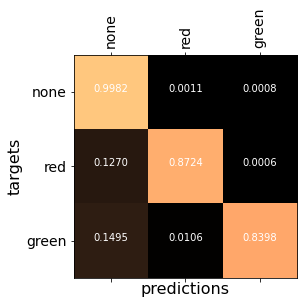

In [ ]:
plot_confusion_matrix(test_loader, model)